<p style="font-size:19px; text-align:left;"><i>Advanced Applications of Generative AI in Actuarial Science: Case Studies Beyond ChatGPT</i></p>
<p style="font-size:25px; text-align:left; font-weight:bold;">Case Study: GenAI-Powered Market Comparison</p>
<p style="font-size:19px; text-align:left; margin-top: -10px; margin-bottom: 15px;">Simon Hatzesberger (<a href="mailto:simon.hatzesberger@gmail.com">simon.hatzesberger@gmail.com</a>), Iris Nonneman (<a href="mailto:irisnonneman@gmail.com">irisnonneman@gmail.com</a>)
<p style="font-style:italic; font-size: 19px">Date: June 1, 2025</p>

<h1 style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px; padding-left: 14px;">Table of Contents</h1>

[1. Overview and Key Takeaways](#overview_and_key_takeaways)

[2. Environment Setup](#environment_setup)

[3. 3-Stage Approach for Market Comparison Generation](#3-stage_approach_for_market_comparison_generation) <br>
&emsp;&emsp;&emsp;[3.1 Stage 1: Preprocessing](#stage_1_preprocessing) <br>
&emsp;&emsp;&emsp;[3.2 Stage 2: Prompt Augmenting](#stage_2_prompt_augmenting) <br>
&emsp;&emsp;&emsp;[3.3 Stage 3: Response Generation](#stage_3_response_generation) <br>
&emsp;&emsp;&emsp;[3.4 Evaluation and Insights](#evaluation_and_insights)

<h1 id="overview_and_key_takeaways" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px;  padding-left: 14px;">1. Overview and Key Takeaways</h1>

This case study explores the application of Generative AI to conduct market comparisons, specifically addressing financial and insurance data within the annual reports of insurance companies. The process of extracting and harmonizing the data of interest for a comparative analysis is typically challenging due to varying and non-standardized structures in the reports, often requiring labor-intensive manual effort prone to errors and inefficiencies. These publicly available reports are a rich yet complex source of information, containing diverse formats and content types. We demonstrate how GenAI can streamline the extraction and comparison of key aspects from annual reports of some of Europe's largest insurance groups (AXA, Generali, and Zurich).

Generative AI offers capabilities particularly well-suited for addressing these challenges due to its ability to effectively process unstructured data. This facilitates faster and more accurate extraction of both numerical data (e.g., regulatory capital ratios under Solvency II or SST, contractual service margins, discount rates for insurance contract valuations by year and currency) and textual data (e.g., strategies for assessing and mitigating cyber risk, sensitivity analyses). While the focus here is on financial and insurance data in annual reports, the methodology is highly adaptable and can be applied, for example, to comparisons of sustainability reports, risk reports, or tariff information (such as services and pricing across different insurance products within a specific market).

The key takeaways for actuarial practice from this case study are as follows:

- The **RAG framework proves its value by effectively identifying and extracting relevant sections** from large and complex input documents. This capability addresses the inherent limitations of LLM context windows, allowing actuaries to access precise, focused information from lengthy and technical reports.

- **Structured Outputs play a crucial role in ensuring that extracted insights are consistently formatted**, which is essential for their seamless integration into further analysis pipelines. By standardizing outputs, this approach reduces variability and supports reliable downstream processing across diverse data sources and reporting standards.

- **Actuarial expertise remains indispensable** at multiple stages of the process. Domain knowledge is important for refining prompts, validating results, and setting output structures to specific use cases. The quality and relevance of AI-generated insights depend on these adjustments, underscoring the need for actuarial professionals to guide and oversee the application of Generative AI in practice.

- The current **approach is particularly effective for the selected aspects of annual reports** – solvency capitalization ratios, interest rates, and cyber risk strategies – which are well-defined and structured. However, applying the same methods to less structured or more complex areas often requires iterative refinement, careful oversight, and tailored prompt engineering to achieve similarly robust results.

- **When the desired information is not present in a document, it is important to have strategies in place to handle such cases explicitly**. For example, instructing the AI model to indicate when no appropriate context is found helps prevent misleading outputs and ensures that analysts are aware of data limitations.

- While the entire data extraction and comparison process could, in theory, be fully automated, **maintaining human oversight is strongly recommended**. Providing actuaries with interim outputs – such as extracted text chunks for review or comparisons with historical results – supports validation, ensures accuracy, and reinforces trust in AI-driven analyses.

The remainder of this notebook is organized as follows. [Section 1](#overview_and_key_takeaways) provides an overview of the case study along with key takeaways. [Section 2](#environment_setup) describes the environment setup, including the required packages and data sources. [Section 3](#3-stage_approach_for_market_comparison_generation) outlines the 3-Stage Approach for Market Comparison Generation, which includes Stage 1: Preprocessing ([Subsection 3.1](#stage_1_preprocessing)), Stage 2: Prompt Augmenting ([Subsection 3.2](#stage_2_prompt_augmenting)), and Stage 3: Response Generation ([Subsection 3.3](#stage_3_response_generation)). The outcomes and insights from these stages are then analyzed in [Subsection 3.4](#evaluation_and_insights).

<h1 id="environment_setup" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px;  padding-left: 14px;">2. Environment Setup</h1>

This section focuses on importing required libraries and establishing configurations for data processing, API integration, and other functional capabilities necessary for our market comparison task.

First, we import the required libraries to ensure all tools are available for subsequent data processing.

In [1]:
# Import essential libraries for data processing and analysis
import numpy as np
import pandas as pd

# Configure pandas display options for enhanced readability
pd.set_option('display.max_colwidth', 3000)
pd.set_option('display.max_columns', None)

# Import package for PDF processing
import fitz  # PyMuPDF

# Import OpenAI API for accessing language and embeddings models
import openai

# Import libraries for structured data handling
from pydantic import BaseModel
from typing import List, Literal

# Import utilities for file operations and pattern matching
import os
import re

# Import library for HTTP requests and file downloads
import requests

# Import library for working with JSON data
import json

# Import machine learning metric for vector similarity calculations
from sklearn.metrics.pairwise import cosine_similarity

# Import utility to display Markdown in Jupyter notebooks
from IPython.display import display

# Import library for random number generation
import random

# Random seed initialization
RANDOM_SEED = 42

Next, we set up the OpenAI API client by retrieving the API key from a previously stored environment variable named `OPENAI_API_KEY`. Alternatively, the API key can also be loaded from a text file or hard-coded directly into the code, though storing it in an environment variable is the recommended practice for security reasons. The API key must be obtained by signing up on the OpenAI platform. Note that using the OpenAI API incurs costs; detailed information can be found on [OpenAI’s pricing page](https://openai.com/pricing).


In [2]:
# Set up the OpenAI client for API communication
client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

The final step of this section involves fetching the annual reports of the large European insurers AXA, Generali, and Zurich. These reports serve as the data sources for this market comparison case study. In the subsequent section, we will focus on extracting and comparing key aspects from these documents.

In [3]:
# Links to annual reports
annual_report_urls = {
    "AXA": "https://www-axa-com.cdn.axa-contento-118412.eu/www-axa-com/fd85b507-f97f-4ac5-861b-6b2b90e1c601_AXA_URD2024_EN.pdf",
    "Generali": "https://www.generali.com/doc/jcr:259c5d6e-46f7-4a43-9512-58e5dcbd2a56/lang:en/Annual%20Integrated%20Report%20and%20Consolidated%20Financial%20Statements%202024_Generali%20Group_final_interactive.pdf",
    "Zurich": "https://edge.sitecorecloud.io/zurichinsur6934-zwpcorp-prod-ae5e/media/project/zurich/dotcom/investor-relations/docs/financial-reports/2024/annual-report-2024-en.pdf"
}

# Directory to temporarily save downloaded annual reports
save_dir = "./annual_reports/"
os.makedirs(save_dir, exist_ok=True)

# Download each PDF and handle success or errors
for company, url in annual_report_urls.items():
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error on bad responses
        file_path = os.path.join(save_dir, f"{company}.pdf")
        with open(file_path, 'wb') as f:
            f.write(response.content)
    except Exception as e:
        print(f"Failed to fetch annual report of {company}: {e}")
    else:
        print(f"Fetch annual report of {company} was successful.")

Fetch annual report of AXA was successful.
Fetch annual report of Generali was successful.
Fetch annual report of Zurich was successful.


<h1 id="3-stage_approach_for_market_comparison_generation" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px;  padding-left: 14px;">3. 3-Stage Approach for Market Comparison Generation</h1>

The following diagram illustrates our three-stage approach for extracting the desired key aspects: Preprocessing, Prompt Augmenting, and Response Generation. This pipeline demonstrates how Generative AI techniques, including Retrieval-Augmented Generation (RAG) and Structured Outputs, are applied to transform raw data from annual reports into structured responses in a user-prespecified format.

<center>
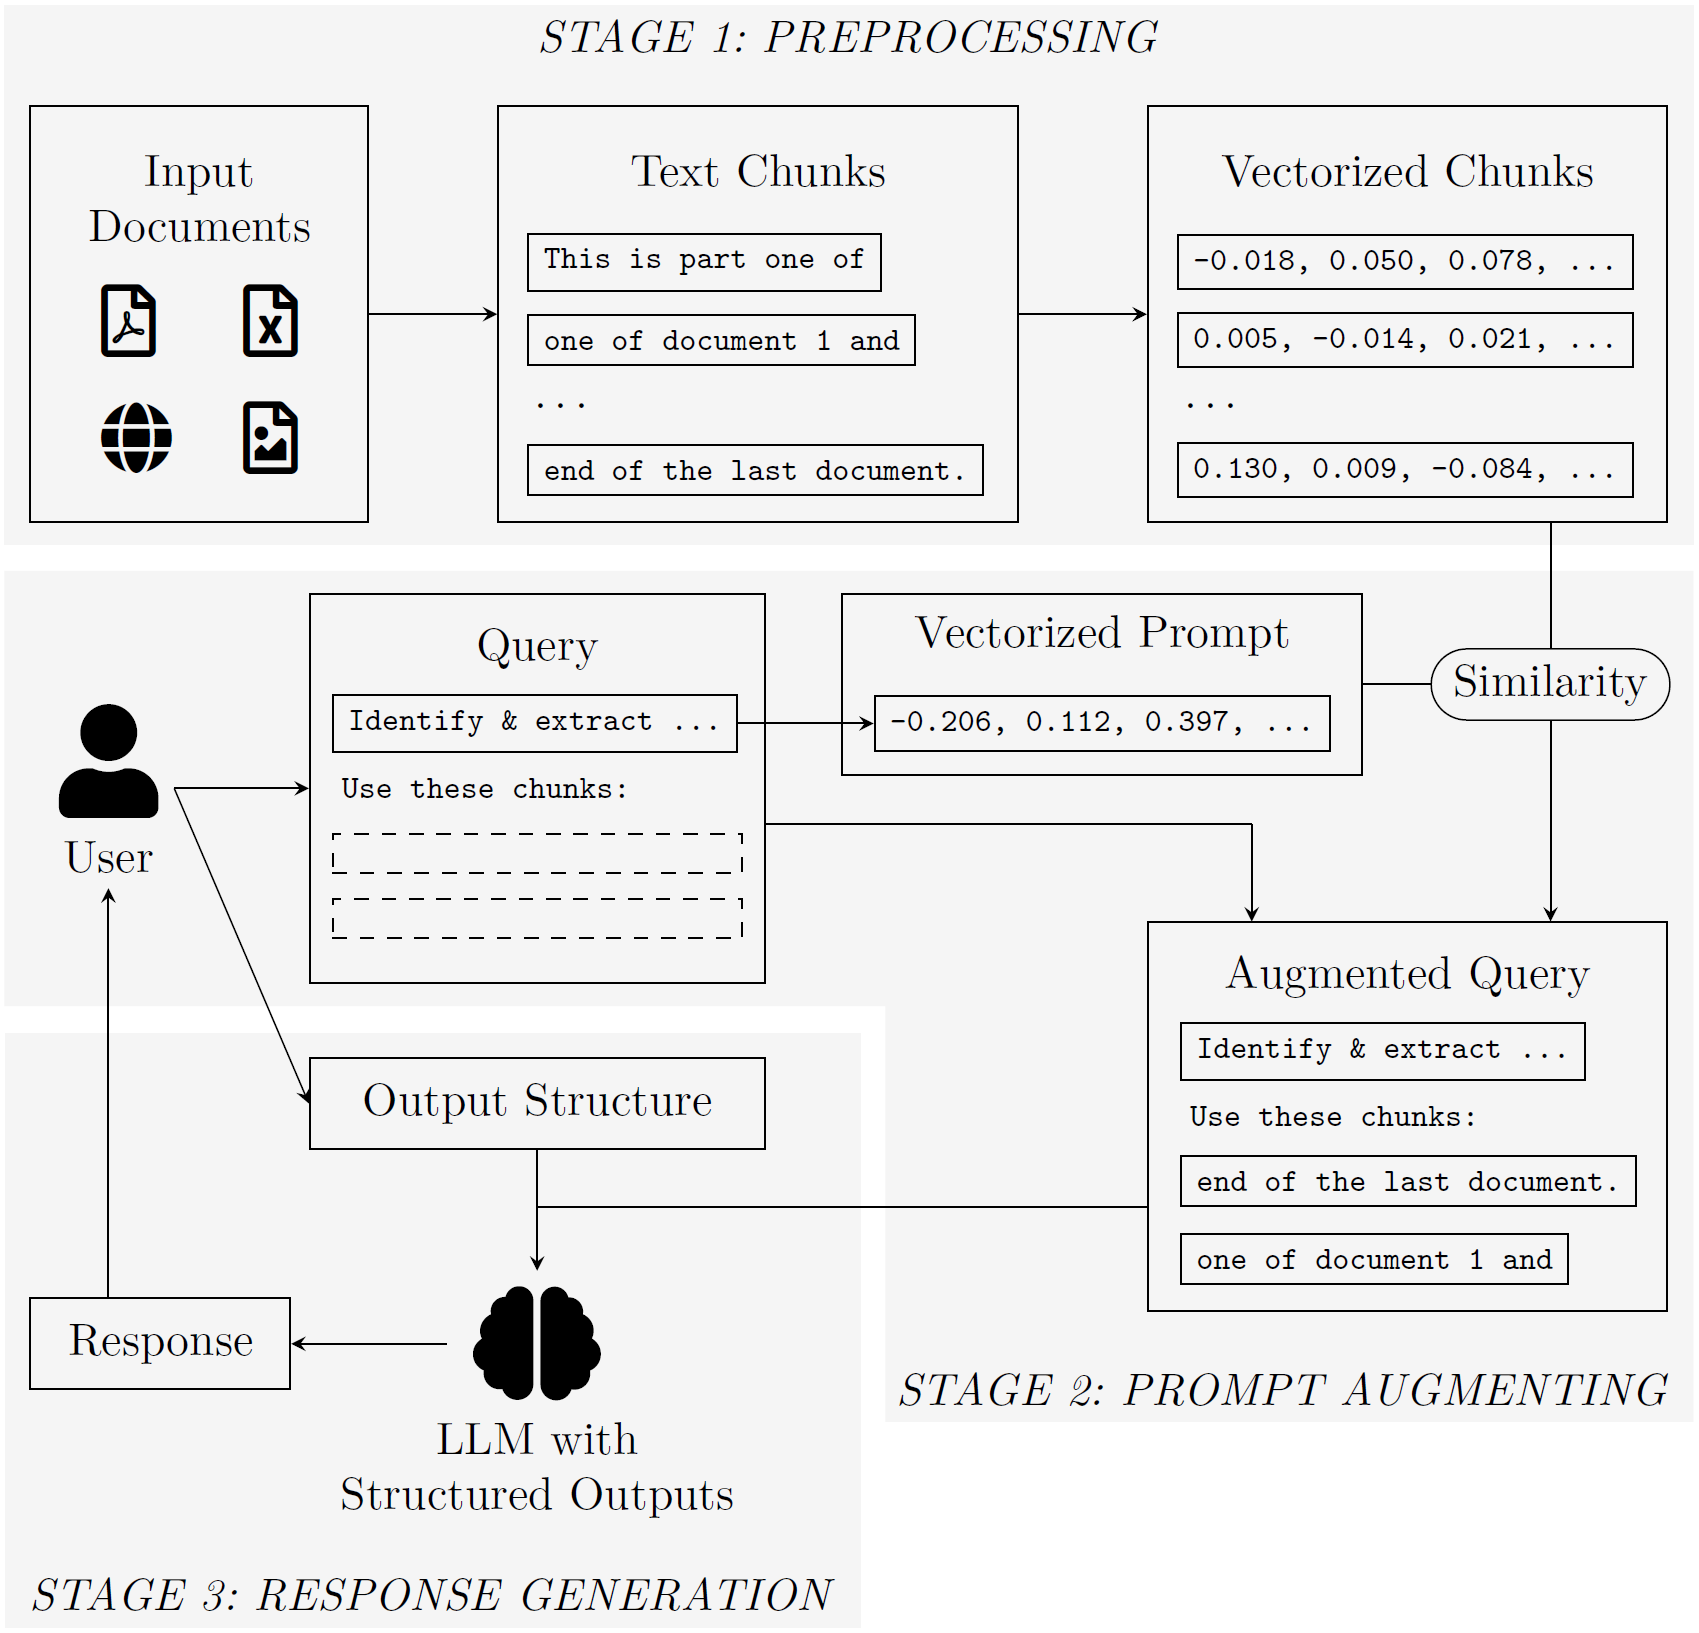
</center>

In [4]:
# Specify the large language model and embeddings model
LARGE_LANGUAGE_MODEL = "gpt-4.1-2025-04-14"
EMBEDDINGS_MODEL = "text-embedding-3-small"

# Reuse the insurer names defined in report_urls
company_names = list(annual_report_urls.keys())

# Parameters for text chunking and retrieval in the RAG framework below
CHUNK_SIZE = 2000      # Maximum characters per chunk
OVERLAP = 300          # Characters of overlap between chunks
TOP_N = 7              # Number of top similar chunks to retrieve
THRESHOLD = 0.5        # Minimum cosine similarity for retrieval

<h1 id="stage_1_preprocessing"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    3.1 Stage 1: Preprocessing
    <a class="anchor-link"
       href="#stage_1_preprocessing"
       target="_self"
       rel="noopener noreferrer">
    </a>
    <hr style="border: none; border-top: 3px solid; margin-top: 10px;">
</h1>

The goal of the first stage is to prepare each input document for efficient similarity-based retrieval. This process involves loading and converting the document to plain text, cleansing and chunking the content, and then vectorizing it using an embedding model.

We first define a function that reads and extracts the content from a list of PDF files, returning a dictionary for each file containing the company name and its full text. The PyMuPDF (`fitz`) package is used for PDF parsing, but other libraries could be used as well.

In [5]:
def load_pdfs(save_dir: str, companies: list[str]) -> list[dict]:
    """
    Loads each company PDF and extracts its full text.
    """
    docs = []
    for company in companies:
        path = os.path.join(save_dir, f"{company}.pdf")
        with fitz.open(path) as pdf:
            text = "".join(page.get_text() for page in pdf)
        docs.append({"company": company, "text": text})
    return docs

Before chunking and vectorizing the text, we apply a cleaning function to ensure consistent formatting. This function normalizes whitespace, removes redundant spaces and empty lines, and preserves the essential content, preparing the text for further processing.

In [6]:
def clean_text(text: str) -> str:
    """
    Normalizes whitespace, strips empty lines, and preserves semantic content.
    """
    # collapse spaces and tabs
    cleaned = re.sub(r"[ \t]+", " ", text)
    # strip each line
    cleaned = "\n".join(line.strip() for line in cleaned.splitlines())
    # remove consecutive empty lines
    cleaned = re.sub(r"\n\s*\n+", "\n\n", cleaned)
    return cleaned

Next, we define a function to split the cleaned text into overlapping chunks. The chunking is done by breaking the text after a fixed number of characters, with an overlap between adjacent chunks. This ensures that each chunk contains enough context for retrieval tasks. An alternative approach could involve splitting by tokens or ensuring that chunks don't cut through sentences, but for simplicity, we use character-based chunking in this example.

In [7]:
def create_chunks(text: str, chunk_size: int = CHUNK_SIZE, overlap: int = OVERLAP) -> list[str]:
    """
    Splits text into overlapping chunks of size chunk_size with given overlap.
    """
    step = chunk_size - overlap
    if step <= 0:
        raise ValueError("chunk_size must be greater than overlap")
    return [text[i : i + chunk_size] for i in range(0, len(text), step)]

To generate embeddings for the text, we use a pre-trained OpenAI embeddings model. The embeddings aim at encoding the semantic meaning of the text as a high-dimensional numerical vector, which will be used for similarity-based retrieval. While we use OpenAI's embeddings model in this example, readers are free to explore other models depending on their specific needs.

In [8]:
def generate_text_embedding(chunk: str, model: str = EMBEDDINGS_MODEL) -> list[float]:
    """
    Generates a vector embedding for the given text chunk.
    """
    resp = client.embeddings.create(
        model=model,
        input=chunk,
        encoding_format="float"
    )
    return resp.data[0].embedding

We now execute Stage 1 by applying the functions defined above: loading the annual reports, cleaning the text, splitting it into chunks, and generating embeddings. For each chunk, we store the company name, chunk content, and embedding, preparing the data for comparison and analysis.

In [9]:
# Execute Stage 1
documents = load_pdfs(save_dir, company_names)

embeddings_data = []
for doc in documents:
    cleaned = clean_text(doc["text"])
    for chunk in create_chunks(cleaned):
        embedding = generate_text_embedding(chunk)
        embeddings_data.append({
            "company": doc["company"],
            "chunk": chunk,
            "embedding": embedding
        })

It is crucial to confirm that Stage 1 has been executed correctly, as all subsequent steps depend on the accurate extraction of text and tables. To verify this, we convert `embeddings_data` into a DataFrame, filter it for a specific insurer, and select a random contiguous block of `n_samples` chunks. By inspecting these sequential samples, we can ensure – at least on a pointwise basis – that both the text and any tabular content have been properly cleaned, chunked, and embedded before proceeding.

In [10]:
# Parameters for inspection
company_to_inspect = "AXA"   # one of: "AXA", "Generali", "Zurich"
n_samples = 3                # number of sequential chunks to display

# Build a DataFrame from embeddings_data
df_embeddings = pd.DataFrame(embeddings_data)

# Filter for the selected company
df_company = df_embeddings[df_embeddings["company"] == company_to_inspect]

if not df_company.empty and len(df_company) >= n_samples:
    max_start = len(df_company) - n_samples
    start_idx = random.randint(0, max_start)
    sample_rows = df_company.iloc[start_idx : start_idx + n_samples]
    display(sample_rows)
else:
    print(f"Not enough embeddings for {company_to_inspect} (found {len(df_company)} rows).")

,company,chunk,embedding
562,AXA,"responsible for ensuring that\nthe AXA entity has processes and frameworks in place that are\nin line with the Group’s Health & Well‑being and Safety Policy.\nAs part of the Safety Management System, all AXA entities are\nrequired to report work‑related accidents (if any) to the Group\non a quarterly basis.\nAs a business partner\nTo monitor compliance of certain selected AXA entities against\nvigilance law requirements, the Group relies on a reporting\nprocess known as the AXA Entities Sustainability Index (“AESI”)\n(described in further detail below), which is based on an\ninternal review conducted by the Group Sustainability team. In\naddition, all local procurement teams are required to comply\nwith the mandatory requirements and objectives set out in the\nGroup Sustainability Standard, including the enhanced\nrequirements set out in the Sustainable Procurement\nGuidelines in relation to their suppliers and subcontractors.\nThe actions required of Group entities pursuant to the\nSustainable Procurement Guidelines are described in the\nsection below entitled “Actions to mitigate risks and prevent\nserious harm – As a Company – Protection of the Environment”.\nmobile communications;\n●\ngifts and branded goods;\n●\nfood and catering;\n●\nbuilding services - cleaning; and\n●\nbusiness process outsourcing (BPO) services (particularly in\ngeographies considered to be of “high criticality”\n).\n●\n(1)\nAXA identifies geographies as ""high criticality"" for business process outsourcing (BPO) services based on the complexity and expertise required for the\ntasks, as well as the industry, technology, and specific requirements of the outsourcing tasks. Additionally, geographies are classified as ""high criticality""\nbased on the Vdem Civil Liberties index processed by Our World in Data Global Change Data Lab, which assesses factors such as forced labor and\nfreedoms, indicating high‑risk areas.\n(1)\nAXA | Universal Registration Document 2024\n274\n2\n5\n3\n4\n6\n7\nA\n1\n4\nSustainability\n4.7 Vigilance Plan\n4.7.3.3\n4.7.3.4","[-0.0038595586, 0.04223544, 0.105929635, 0.02242938, -0.004620321, 0.019281397, -0.033080056, -0.013188737, 0.039061226, -0.025918394, 0.018861666, -0.07361034, -0.011142549, -0.036280505, 0.011031058, 0.029223777, 0.0021707967, -0.0006382044, -0.02246873, -0.037067503, 0.018743617, 0.08158523, -0.030273104, 0.037513465, -0.057713024, -0.03992692, -0.018494401, -0.0024380474, 0.021104604, -0.02284911, 0.09569869, -0.024698552, 0.021065254, 0.019202698, -0.0028954886, -0.0023249167, -0.027571086, 0.015123436, 0.047691945, -0.006945238, 0.014493839, -0.018494401, -0.033237457, -0.0049383985, -0.029276244, 0.0020199558, -0.0021281678, -0.008309364, -0.021025904, 0.048400242, -0.01129339, -0.009988288, 0.048924904, -0.0046006464, -0.03680517, 0.002077341, -0.0038792335, 0.020186443, 0.008965194, 0.033893287, -0.026889022, -0.027413687, -0.028489247, 0.022822877, -0.016999109, 0.01861245, -0.014598772, 0.044176698, 0.01371996, -0.031584766, 0.029591043, 0.046222888, 0.040871315, -0.0013895395, 0.02250808, 0.0028036726, 0.011490138, 0.023754157, -0.025131399, 0.024974, -0.038720194, 0.015162786, -0.05808029, 0.049948, -0.021655502, -0.039218623, -0.05676863, 0.020278258, -0.052702487, 0.03284396, -0.018717384, 0.014611889, -0.052046657, 0.0030660045, 0.019661779, 0.0038825127, 0.024029605, 0.005558158, 0.0022790087, 0.02350494, ...]"
563,AXA,"\nbased on the Vdem Civil Liberties index processed by Our World in Data Global Change Data Lab, which assesses factors such as forced labor and\nfreedoms, indicating high‑risk areas.\n(1)\nAXA | Universal Registration Document 2024\n274\n2\n5\n3\n4\n6\n7\nA\n1\n4\nSustainability\n4.7 Vigilance Plan\n4.7.3.3\n4.7.3.4\nFor details on the results of this year’s AESI reporting process,\nplease refer to the section below entitled “Monitoring the\neffective implementation of the vigilance measures”.\nTo implement improved procedures for regular a

<h1 id="stage_2_prompt_augmenting"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    3.2 Stage 2: Prompt Augmenting
    <a class="anchor-link"
       href="#stage_2_prompt_augmenting"
       target="_self"
       rel="noopener noreferrer">
    </a>
    <hr style="border: none; border-top: 3px solid; margin-top: 10px;">
</h1>

While the first stage is largely independent of the specific information we aim to extract and needs to be conducted only once, Stage 2 focuses on identifying the relevant context within the input documents for each of the three key aspects (regulatory capital ratios under Solvency II or SST, discount rates for insurance contract valuations by duration, and strategies for assessing and mitigating cyber risk).

We start by defining a system prompt that provides context for the LLM employed later. This prompt is used for each query to ensure consistent extraction of structured information from the documents.

In [11]:
# Define an enhanced system prompt for RAG + Structured Outputs
system_prompt = """
You are an AI assistant specialized in extracting and structuring key financial
and risk insights from annual reports of European insurance companies. Use RAG
to retrieve precise text segments and apply Structured Outputs to format data
consistently. Identify and extract regulatory ratios, discount rates, and cyber
risk strategies with exact numerical formats and contextual clarity. Ensure all
outputs follow the specified schema for seamless integration into actuarial
workflows and to support robust comparative analysis.
"""

To guide the similarity search and the LLM, we define detailed prompts that specify the specific information to extract, the relevant context, and the desired presentation. These prompts target exactly three aspects: solvency ratios, discount rates, and cybersecurity risk strategies.

In [12]:
# Prompt for extracting solvency capital ratios specifically for the year 2024
prompt_solvency_ratio = """
Extract the group's solvency capital ratio in percentage for 2024, along with
the regulatory framework (Solvency II or SST).
"""

# Prompt for retrieving discount rate data specifically for the year 2024
prompt_discount_rates = """
Extract the discount rates for financial or insurance contract
liabilities in 2024, using only currency EUR.
For each duration (e.g., 1 year, 5 years, 10 years, 20 years, 40 years, etc.),
extract the corresponding discount rate in percentage.
Ensure that the data reflects the rates as of December 31, 2024.
If no specific approach is mentioned, assume non-VFA,
unit-linked contracts, or liquid products.
"""

# Prompt for identifying cybersecurity risk management strategies
prompt_cyber_risk_strategies = """
Extract the insurer's documented approach to cyber-risk assessment
and mitigation.
Return each policy, process, or control as a separate text bullet,
and include any references to governance bodies,
frequency of reviews, or related quantitative metrics if available.
"""

# Store all prompts in a list for easy access
prompts = [prompt_solvency_ratio, prompt_discount_rates, prompt_cyber_risk_strategies]

Given the document embeddings and a prompt for a specific aspect, this function performs a vector-based similarity search to identify the most relevant text chunks. It generates an embedding for the prompt using the same embedding model, computes cosine similarity with each document chunk, and ranks the results based on their similarity scores. The top matching chunks are then formatted for use in an augmented query for the LLM.

In [13]:
def retrieve_top_matching_chunks(
    document_embeddings: list[dict],
    prompt: str,
    max_results: int = TOP_N,
    similarity_cutoff: float = THRESHOLD
) -> str:
    """
    Identify and return the most relevant text chunks, including their similarity scores.
    """
    prompt_embedding = generate_text_embedding(prompt)
    if not prompt_embedding:
        return "No relevant content found."

    prompt_vec = np.array(prompt_embedding).reshape(1, -1)
    df = pd.DataFrame(document_embeddings)
    df['similarity'] = df['embedding'].apply(
        lambda emb: cosine_similarity(prompt_vec, np.array(emb).reshape(1, -1))[0, 0]
    )

    df_filtered = df[df['similarity'] >= similarity_cutoff]
    if df_filtered.empty:
        return "No relevant content found."

    top = df_filtered.nlargest(max_results, 'similarity')
    retrieved_chunks = [
        f"========================================================================\n"
        f"Chunk {i} ({row['company']}, similarity score = {row['similarity']:.2f}):\n"
        f"------------------------------------------------------------------------\n"
        f"{row['content']}"
        for i, (_, row) in enumerate(top.iterrows(), start=1)
    ]
    return "\n\n".join(retrieved_chunks)

The following code retrieves relevant information from the companies' annual reports by matching predefined prompts with each company's document embeddings. It iterates through the list of companies, filters their embeddings, and identifies the most relevant text chunks for each query.

In [14]:
# Build a single DataFrame from all embeddings
df_embeddings = pd.DataFrame(embeddings_data)

# Prepare storage for retrieved results
company_retrieved_data = {}

# Human-readable labels for each query
query_labels = ["solvency_ratio", "discount_rates", "cyber_risk_strategies"]

for company in company_names:
    # Filter the DataFrame for the current company
    df_comp = df_embeddings[df_embeddings["company"] == company]
    if df_comp.empty:
        print(f"Warning: no embeddings for {company}, skipping.")
        continue

    # Convert the filtered rows into a list of dicts for retrieval
    docs = df_comp.rename(columns={"chunk": "content"}).to_dict("records")
    company_retrieved_data[company] = {}

    # Run each prompt and store the formatted chunks
    for label, prompt in zip(query_labels, prompts):
        company_retrieved_data[company][label] = retrieve_top_matching_chunks(
            document_embeddings=docs,
            prompt=prompt,
            max_results=7,
            similarity_cutoff=THRESHOLD
        )

To verify the correctness and relevance of the retrieved information, we can perform a check for a specific company and prompt. This step ensures that the data retrieval process is functioning as expected and provides an example of the most relevant context for a given company-prompt combination.

In [15]:
company_to_check = "AXA"            # one of: "AXA", "Generali", "Zurich"
label_to_check = "discount_rates"   # one of: "solvency_ratio", "discount_rates", "cyber_risk_strategies"

# Map labels back to their query texts
query_map = dict(zip(query_labels, prompts))
query_text = query_map[label_to_check]

# Fetch the stored result
company_data = company_retrieved_data.get(company_to_check, {})
retrieved = company_data.get(label_to_check)

if retrieved:
    print(f"--- Example for {company_to_check} [{label_to_check}] ---\n")
    print(retrieved)
else:
    print(f"No data found for {company_to_check} with label '{label_to_check}'.")

--- Example for AXA [discount_rates] ---

Chunk 1 (AXA, similarity score = 0.65):
------------------------------------------------------------------------
asualty
66
42
28
22
17
46
32
253
CSM arising from insurance
contracts and investment
contracts with DPF
2,633
2,368
2,163
1,992
1,838
7,331
16,601
34,927
Life & Health
64
61
57
52
48
165
246
693
Property & Casualty
15
9
6
4
3
6
4
46
CSM arising from reinsurance
contracts held
79
70
63
56
51
170
250
740

12.1.6
Discount rates
As explained in the Note 1.14.3.3, the estimates of future cash flows are discounted based on yield curves determined in a
“risk‑neutral” environment. The yield curves used as of December 31, 2024, and December 31, 2023 for the main currencies are
disclosed below.
Maturity
Spot discount rates used at end December
EUR
USD
GBP
JPY
CHF
HKD
2024
2023
2024
2023
2024
2023
2024
2023
2024
2023
2024
2023
1
2.7%
3.7%
4.8%
5.4%
4.9%
5.2%
0.4%
(0.1%)
0.0%
1.1%
4.1%
4.5%
2
2.5%
3.0%
4.7%
4.7%
4.7%
4.5%
0.5%
0.0%
0.0%
1.1%
4.0

<h1 id="stage_3_response_generation"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    3.3 Stage 3: Response Generation
    <a class="anchor-link"
       href="#stage_3_response_generation"
       target="_self"
       rel="noopener noreferrer">
    </a>
    <hr style="border: none; border-top: 3px solid; margin-top: 10px;">
</h1>

The final stage involves combining the augmented query from the previous stage with a predefined output structure for each aspect of interest, ensuring that an LLM with Structured Outputs capabilities adheres to this specific format in its response.

To ensure consistent and structured results, we define output schemas for each key aspect of interest. These schemas guide the LLM to generate responses in a predefined format, making the data machine-readable as well as easy to analyze and to compare. The following code block outlines the structure for solvency ratios, discount rates, and cyber risk strategies.

In [16]:
# Solvency ratio schema: percentage and regulatory framework
class SolvencyRatioSchema(BaseModel):
    capital_ratio: int          # solvency ratio in %
    regulatory_framework: Literal["Solvency II", "SST"]

schema_solvency_ratio = SolvencyRatioSchema

# Discount rate for a specific duration
class DiscountRatePerDuration(BaseModel):
    duration_year: int          # duration in years
    discount_rate: float        # rate in percentage as decimal (e.g., 2.47)

# Aggregate discount rates across durations
class DiscountRatesSchema(BaseModel):
    discount_rates_per_duration: List[DiscountRatePerDuration]  # list by duration

schema_discount_rates = DiscountRatesSchema

# Cyber risk mitigation strategies list
class CyberRiskStrategiesSchema(BaseModel):
    strategies: List[str]       # mitigation policies or controls

schema_cyber_risk = CyberRiskStrategiesSchema

We organize the predefined prompts and their corresponding schemas into a `QUERY_CONFIG` dictionary, using descriptive labels as keys for easy access during retrieval and analysis.

In [17]:
# Update your QUERY_CONFIG to use labels as keys
QUERY_CONFIG = {
    "solvency_ratio": {
        "prompt": prompt_solvency_ratio,
        "schema": schema_solvency_ratio
    },
    "discount_rates": {
        "prompt": prompt_discount_rates,
        "schema": schema_discount_rates
    },
    "cyber_risk_strategies": {
        "prompt": prompt_cyber_risk_strategies,
        "schema": schema_cyber_risk
    }
}

The function below retrieves relevant data based on a company and query, then combines it with the required Structured Outputs format. This ensures the LLM generates a response that adheres to the specified schema.

In [18]:
def query_structured_output(
    company: str,
    label: str,
    system_prompt: str,
    model: str = LARGE_LANGUAGE_MODEL
) -> BaseModel | dict:
    """
    Run a RAG query to extract structured data from retrieved chunks.

    :param company: Insurer name (must exist in company_retrieved_data).
    :param label: One of the keys in QUERY_CONFIG, e.g. "solvency_ratio".
    :param system_prompt: Guiding system prompt.
    :param model: LLM identifier.
    :return: Parsed Pydantic model instance or error dict.
    """
    # 1. Get the chunks by label
    chunks = company_retrieved_data.get(company, {}).get(label, "")
    if not chunks:
        return {"error": f"No retrieved chunks for {company} / {label}."}

    # 2. Look up the matching prompt text and schema
    prompt = QUERY_CONFIG[label]["prompt"]
    schema = QUERY_CONFIG[label]["schema"]

    # 3. Build the augmented query
    #    We embed the Pydantic schema in the query so the model sees it,
    #    but the Responses API will still enforce it via text_format below.
    augmented_query = (
        f"Prompt:\n{prompt}\n\n"
        f"Text Chunks:\n{chunks}\n\n"
        "Extract the required fields according to the schema below.\n"
        f"{json.dumps(schema.model_json_schema(), indent=2)}\n\n"
        "If any field cannot be found, use 'NA'."
    )

    # 4. Call the Responses API's parse() method with `text_format=schema`
    try:
        response = client.responses.parse(  
            model=model,  
            input=[  
                {"role": "system", "content": system_prompt},  
                {"role": "user",   "content": augmented_query}  
            ],  
            temperature=0.1,  
            text_format=schema  
        )
        # 5. Return the validated Pydantic object  
        return response.output_parsed  

    except openai.OpenAIError as e:  
        return {"error": str(e)}

Before extracting and structuring the relevant data, each query must be paired with its corresponding response format. This mapping ensures that the extracted information aligns with the expected schema for each aspect of interest. The following code handles this by iterating over all companies and query labels, generating structured outputs ready for further analysis.

In [19]:
# Prepare results container
results = {"Company": []}
for label in QUERY_CONFIG:
    results[label] = []

# Iterate insurers × labels
for company in company_names:
    results["Company"].append(company)
    for label in QUERY_CONFIG:
        result = query_structured_output(
            company=company,
            label=label,
            system_prompt=system_prompt
        )
        results[label].append(result)

<h1 id="evaluation_and_insights"
    style="font-size:20px; font-weight:bold; margin-top: 10px;">
    3.4 Evaluation and Insights
    <a class="anchor-link"
       href="#evaluation_and_insights"
       target="_self"
       rel="noopener noreferrer">
    </a>
    <hr style="border: none; border-top: 3px solid; margin-top: 10px;">
</h1>

We now compile the structured outputs into a single DataFrame for easy inspection. The DataFrame summarizes the extracted information across the targeted aspects – solvency ratios, discount rates, and cybersecurity risk strategies – providing a clear overview of the results for each company.

In [20]:
# Build and display results DataFrame
results_df = (
    pd.DataFrame(results)
      .set_index("Company")
      .rename(columns=lambda c: c.replace("_", " ").title())
)
results_df

,Solvency Ratio,Discount Rates,Cyber Risk Strategies
Company,,,
AXA,capital_ratio=216 regulatory_framework='Solvency II',"discount_rates_per_duration=[DiscountRatePerDuration(duration_year=1, discount_rate=2.7), DiscountRatePerDuration(duration_year=2, discount_rate=2.5), DiscountRatePerDuration(duration_year=3, discount_rate=2.5), DiscountRatePerDuration(duration_year=5, discount_rate=2.6), DiscountRatePerDuration(duration_year=7, discount_rate=2.6), DiscountRatePerDuration(duration_year=10, discount_rate=2.7), DiscountRatePerDuration(duration_year=15, discount_rate=2.8), DiscountRatePerDuration(duration_year=20, discount_rate=2.7), DiscountRatePerDuration(duration_year=25, discount_rate=2.6), DiscountRatePerDuration(duration_year=30, discount_rate=2.6)]","strategies=['AXA has developed an Information Risk Management (IRM) framework to ensure consistent information risk decisions and establish integrated and sustainable risk management capabilities throughout the organization.', 'Documentation and practices against the EU Digital Operational Resilience Act (DORA) requirements have been anchored into the IRM framework, in close relationship with Security, IT, and Procurement functions.', 'Onboarding a vendor requires AXA to assess potential risks, including regulatory, compliance, and IT security risks.', 'Both quantitative and qualitative requirements are defined across the Group by identifying and assessing the most critical operational risks of each entity and a set of stress scenarios using a forward-looking and expert-opinion approach.', 'The operational Risk Management process is integrated into local governance through senior management validation to ensure the risk assessment is adequate and appropriate.', 'Local Compliance functions undertake an annual Compliance Risk Assessment to identify major compliance risks, including cyber risk, and develop an Annual Compliance Plan.', 'The local Compliance function reports regularly to local senior management and the local Audit Committee on significant compliance matters, including key compliance risks and outstanding action points.', 'The Board of Directors reviews the Company’s ICT risk management framework and digital operational resilience strategy, including cybersecurity, as required by DORA.', 'Quarterly reports on information security, IT resilience, and physical security are provided to the Board of Directors.', 'Bi-annual reports on compliance, including IT & security matters (such as cybersecurity), are discussed at the Board level.', ""Renewal of the Group's insurance policies, including cyber risk coverage, is reviewed by the Board of Directors."", 'Internal Audit includes ICT audits in its annual plan and reviews the effectiveness of the risk management and internal control frameworks, including cybersecurity.']"
Generali,capital_ratio=210 regulatory_framework='Solvency II',"discount_rates_per_duration=[DiscountRatePerDuration(duration_year=1, discount_rate=2.47), DiscountRatePerDuration(duration_year=2, discount_rate=2.32), DiscountRatePerDuration(duration_year=3, discount_rate=2.32), DiscountRatePerDuration(duration_year=4, discount_rate=2.35), DiscountRatePerDuration(duration_year=5, discount_rate=2.37), DiscountRatePerDuration(duration_year=6, discount_rate=2.4), DiscountRatePerDuration(duration_year=7, discount_rate=2.43), DiscountRatePerDuration(duration_year=8, discount_rate=2.45), DiscountRatePerDuration(duration_year=9, discount_rate=2.47), DiscountRatePerDuration(duration_year=10, discount_rate=2.5), DiscountRatePerDuration(duration_year=15, discount_rate=2.56), DiscountRatePerDuration(duration_year=20, discount_rate=2.49), DiscountRatePerDuration(duration_year=25, discount_rate=2.51), DiscountRatePerDuration(duration_year=30, discount_rate=2.58), DiscountRatePerDuration(duration_year=35, discount_rate=2.65), DiscountRatePerDuration(duration_year=40, discount_rate=2.71), DiscountRatePerDuration(duration_year=45, discount_rate=2.77), DiscountRatePerDura

Our implementation successfully extracted and structured the desired information across the targeted aspects of the annual reports. The outputs consistently adhered to the defined structures and were validated against the original values in the reports, confirming the accuracy and reliability of the approach. In particular, the discount rates were correctly extracted as lists of varying lengths, reflecting the differing numbers of rates stated across the annual reports.

Notably, multiple runs of the system produced identical results for quantitative fields, such as solvency ratios and discount rates, demonstrating stability and reproducibility of the outputs. For the extraction of cyber risk mitigation strategies, minor variations in language were observed across runs; however, the underlying content and key points remained consistent, underscoring the robustness of the approach for extracting structured textual insights.

The results obtained above can be further processed for seamless integration into other workflows, analyses, or comparisons. The demonstrated aspects are just examples – additional topics could be extracted and compared, and the methodology is highly adaptable to other document types beyond annual reports.